In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, get_velocity_evolution, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
outputs = [
    "../outputs/expifr/amd/base",
    "../outputs/expifr_gse/amd/tacc7p2/massratio3/expsigma/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

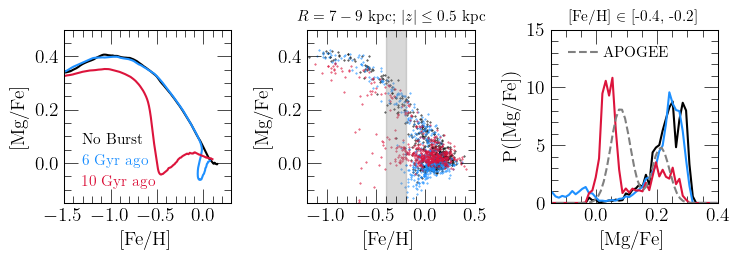

In [11]:
COLORS = ["black", "dodgerblue", "crimson"]
LABELS = ["No Burst", "6 Gyr ago", "10 Gyr ago"]
FEH_ERR = 0.0087
MGFE_ERR = 0.017
FEH_MIN = -0.4
FEH_MAX = -0.2

fig = plt.figure(figsize = (7.5, 2.7))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    if i < 2:
        axes[i].set_xlabel(r"[Fe/H]")
        axes[i].set_ylabel(r"[Mg/Fe]")
        axes[i].set_ylim([-0.15, 0.5])
        axes[i].set_yticks([0, 0.2, 0.4])
    else:
        axes[i].set_xlabel(r"[Mg/Fe]")
        axes[i].set_ylabel(r"P([Mg/Fe])")
        axes[i].set_xlim([-0.15, 0.4])
        axes[i].set_ylim([0, 15])
        axes[i].set_xticks([0, 0.2, 0.4])

axes[0].set_xlim([-1.5, 0.3])
axes[0].set_xticks([-1.5, -1, -0.5, 0])
axes[1].set_xlim([-1.2, 0.5])
axes[1].set_xticks([-1, -0.5, 0, 0.5])
axes[1].set_title(r"$R = 7 - 9$ kpc; $\left|z\right| \leq 0.5$ kpc", fontsize = 11)
axes[2].set_title(r"[Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX), fontsize = 11)

def plot_track(ax, output, radius = 8, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)

def plot_stars(ax, output, rmin = 7, rmax = 9, abszmin = 0, abszmax = 0.5, zone_width = 0.1, N = 500, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", ax.get_xlim()[0]).filter(
        "[fe/h]", "<=", ax.get_xlim()[1]).filter(
        "[mg/fe]", ">=", ax.get_ylim()[0]).filter(
        "[mg/fe]", "<=", ax.get_ylim()[1]).filter(
        "mass", ">", 1)
    stars = subsample_stellar_populations(stars, N = N, seed = seed)
    err_feh = np.random.normal(scale = FEH_ERR, size = N)
    err_mgfe = np.random.normal(scale = MGFE_ERR, size = N)
    for i in range(N):
        stars["[fe/h]"][i] += err_feh[i]
        stars["[mg/fe]"][i] += err_mgfe[i]
    ax.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)

def plot_distribution(ax, output, rmin = 7, rmax = 9, abszmin = 0, abszmax = 0.5, fehmin = FEH_MIN, fehmax = FEH_MAX,
    zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "[mg/fe]", ">=", ax.get_xlim()[0]).filter(
        "[mg/fe]", "<=", ax.get_xlim()[1]).filter(
        "mass", ">=", 1)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 50, range = ax.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, hist, **kwargs)

def plot_observed_distribution(ax, rmin, abszmin, fehmin, **kwargs):
    path = "../data/ofe_mdfs/Rmin%.1f_hmin%.1f_FeHmin%.1f.dat" % (rmin, abszmin, fehmin)
    raw = np.genfromtxt(path)
    ofe = raw[:,-2]
    p_ofe = raw[:,-1]
    dofe = ofe[1] - ofe[0]
    norm = 0
    for i in range(len(ofe)):
        norm += p_ofe[i] * dofe
    p_ofe = [p / norm for p in p_ofe]
    ax.plot(ofe, p_ofe, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "color": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_track(axes[0], outputs[i], **kwargs)
    kwargs["label"] = None
    plot_stars(axes[1], outputs[i], rasterized = True, s = 0.15, **kwargs)
    plot_distribution(axes[2], outputs[i], **kwargs)

plot_observed_distribution(axes[2], 7, 0, FEH_MIN, c = named_colors()["grey"], linestyle = "--", label = "APOGEE")

axes[1].fill_betweenx(axes[1].get_ylim(), 2 * [FEH_MIN], 2 * [FEH_MAX], color = named_colors()["grey"], alpha = 0.3)
# axes[2].text(-0.1, 12, r"[Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX), fontsize = 11)
# axes[2].text(-0.1, 13.5, r"$R = 7 - 9$ kpc", fontsize = 11)
# axes[2].text(-0.1, 11.5, r"$\left|z\right| \leq 0.5$ kpc", fontsize = 11)
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "fontsize": 11,
    "handlelength": 0
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, COLORS)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.02, 0.98),
    "fontsize": 11
}
axes[2].legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./timing/solar-annulus-timingcomp-gsebetaphiin-0p8.%s" % (ext), **kwargs)
plt.show()

In [2]:
outputs = [
    "../outputs/expifr/amd/base",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc5p2/massratio3/expsigma/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc7p2/massratio3/expsigma/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc9p2/massratio3/expsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

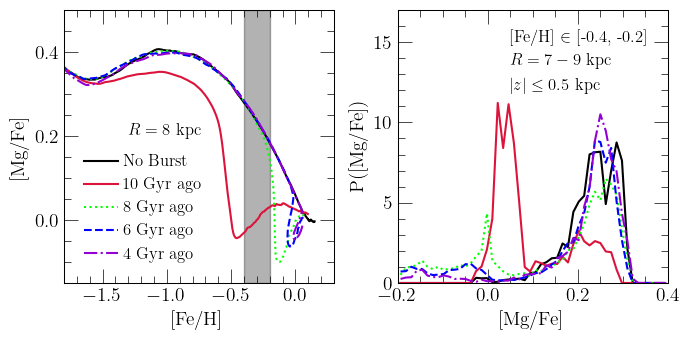

In [8]:
LABELS = ["No Burst", "10 Gyr ago", "8 Gyr ago", "6 Gyr ago", "4 Gyr ago"]
COLORS = ["black", "crimson", "lime", "blue", "darkviolet"]
LINESTYLES = ["-", "-", ":", "--", "-."]
RADIUS = 8
ABSZMIN = 0
ABSZMAX = 0.5
FEH_MIN = -0.4
FEH_MAX = -0.2
FEH_ERR = 0.0087
MGFE_ERR = 0.017

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_xlabel(r"[Fe/H]")
ax1.set_ylabel(r"[Mg/Fe]")
ax1.set_xlim([-1.8, 0.3])
ax1.set_ylim([-0.15, 0.5])
ax1.set_xticks([-1.5, -1, -0.5, 0])
ax1.set_yticks([0, 0.2, 0.4])

ax2.set_xlabel(r"[Mg/Fe]")
ax2.set_ylabel(r"P([Mg/Fe])")
ax2.set_xlim([-0.2, 0.4])
ax2.set_ylim([0, 17])
ax2.set_yticks([0, 5, 10, 15])

def plot_track(ax, output, radius = RADIUS, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)

def plot_distribution(ax, output, rmin, rmax, abszmin, abszmax, fehmin, fehmax,
    zone_width = 0.1, N = 200, seed = 0, **kwargs):
    # stars = output.stars.filter(
    #     "zone_final", ">=", int(rmin / zone_width)).filter(
    #     "zone_final", "<=", int(rmax / zone_width) - 1).filter(
    #     "absz", ">=", abszmin).filter(
    #     "absz", "<=", abszmax).filter(
    #     "mass", ">=", 1)
    # stars = subsample_stellar_populations(stars, N = N, seed = seed)
    # err_feh = np.random.normal(scale = FEH_ERR, size = len(stars["mass"]))
    # err_mgfe = np.random.normal(scale = MGFE_ERR, size = len(stars["mass"]))
    # for i in range(len(stars["mass"])):
    #     stars["[fe/h]"][i] += err_feh[i]
    #     stars["[mg/fe]"][i] += err_mgfe[i]
    # ax_scat.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "mass", ">=", 1)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 50, range = ax.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    if "s" in kwargs.keys(): del kwargs["s"]
    ax.plot(xvals, hist, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_track(ax1, outputs[i], **kwargs)
    plot_distribution(ax2, outputs[i], RADIUS - 1, RADIUS + 1, ABSZMIN, ABSZMAX, FEH_MIN, FEH_MAX, **kwargs)

ax1.fill_between([FEH_MIN, FEH_MAX], 2 * [ax1.get_ylim()[0]], 2 * [ax1.get_ylim()[1]],
    color = named_colors()["black"], alpha = 0.3, zorder = -100)

ax1.text(-1.3, 0.2, r"$R = %d$ kpc" % (RADIUS), fontsize = 12)
ax2.text(0.05, 15, r"[Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX), fontsize = 12)
ax2.text(0.05, 13.5, r"$R = 7 - 9$ kpc", fontsize = 12)
ax2.text(0.05, 12, r"$\left|z\right| \leq 0.5$ kpc", fontsize = 12)

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "ncol": 1,
    "handlelength": 2,
    "fontsize": 12
}
leg = ax1.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./timing/solar-annulus-timingcomp-gsebetaphiin-0p8.%s" % (ext), **kwargs)
plt.show()